In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import label

def initialize_lattice(L):
    return np.random.choice([-1, 1], size=(L, L))

def swendsen_wang_step(lattice, T):
    L = lattice.shape[0]
    p = 1 - np.exp(-2 / T)
    horizontal_bonds = (lattice == np.roll(lattice, -1, axis=1)) & (np.random.rand(L, L) < p)
    vertical_bonds   = (lattice == np.roll(lattice, -1, axis=0)) & (np.random.rand(L, L) < p)

    # Build cluster connectivity mask
    labels = np.arange(L * L).reshape(L, L)
    parent = np.arange(L * L)

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(x, y):
        xroot, yroot = find(x), find(y)
        if xroot != yroot:
            parent[yroot] = xroot

    # Connect horizontal
    for i in range(L):
        for j in range(L):
            if horizontal_bonds[i, j]:
                union(i * L + j, i * L + (j + 1) % L)
            if vertical_bonds[i, j]:
                union(i * L + j, ((i + 1) % L) * L + j)

    # Cluster IDs
    clusters = {}
    for i in range(L):
        for j in range(L):
            root = find(i * L + j)
            if root not in clusters:
                clusters[root] = []
            clusters[root].append((i, j))

    # Flip each cluster with probability 0.5
    for cluster in clusters.values():
        if np.random.rand() < 0.5:
            for (i, j) in cluster:
                lattice[i, j] *= -1

    return lattice

def compute_energy(lattice):
    L = lattice.shape[0]
    E = 0
    for i in range(L):
        for j in range(L):
            S = lattice[i, j]
            neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L]
            E += -S * neighbors
    return E

def compute_magnetization(lattice):
    return np.sum(lattice)

def simulate_sw(L, T, steps, thermalization=0.1):
    lattice = initialize_lattice(L)
    energies, magnetizations = [], []
    therm_steps = int(steps * thermalization)

    for step in range(steps):
        lattice = swendsen_wang_step(lattice, T)
        if step >= therm_steps:
            energy = compute_energy(lattice)
            magnet = compute_magnetization(lattice)
            energies.append(energy)
            magnetizations.append(abs(magnet))

    norm = L * L
    avg_E = np.mean(energies) / norm
    avg_M = np.mean(magnetizations) / norm
    C = (np.var(energies) / T**2) / norm
    chi = (np.var(magnetizations) / T) / norm

    return avg_E, avg_M, C, chi

def run_temperature_sweep_sw(L=20, steps=3000, Tmin=1.5, Tmax=3.5, Tsteps=20):
    T_vals = np.linspace(Tmin, Tmax, Tsteps)
    E_vals, M_vals, C_vals, X_vals = [], [], [], []

    print("Running Swendsen-Wang temperature sweep:")
    for T in tqdm(T_vals):
        avg_E, avg_M, C, chi = simulate_sw(L, T, steps)
        E_vals.append(avg_E)
        M_vals.append(avg_M)
        C_vals.append(C)
        X_vals.append(chi)

    return T_vals, E_vals, M_vals, C_vals, X_vals

def plot_vs_temperature(T, E, M, C, X):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(T, E, 'ro', markersize=6)
    plt.title('Average Energy per Spin')
    plt.xlabel('Temperature')
    plt.ylabel('Energy')

    plt.subplot(2, 2, 2)
    plt.plot(T, M, 'bo', markersize=6)
    plt.title('Average Magnetization per Spin')
    plt.xlabel('Temperature')
    plt.ylabel('Magnetization')

    plt.subplot(2, 2, 3)
    plt.plot(T, C, 'go', markersize=6)
    plt.title('Specific Heat per Spin')
    plt.xlabel('Temperature')
    plt.ylabel('Specific Heat')

    plt.subplot(2, 2, 4)
    plt.plot(T, X, 'mo', markersize=6)
    plt.title('Susceptibility per Spin')
    plt.xlabel('Temperature')
    plt.ylabel('Susceptibility')

    plt.tight_layout()
    plt.show()


Running Swendsen-Wang temperature sweep:


100%|██████████| 20/20 [01:46<00:00,  5.34s/it]


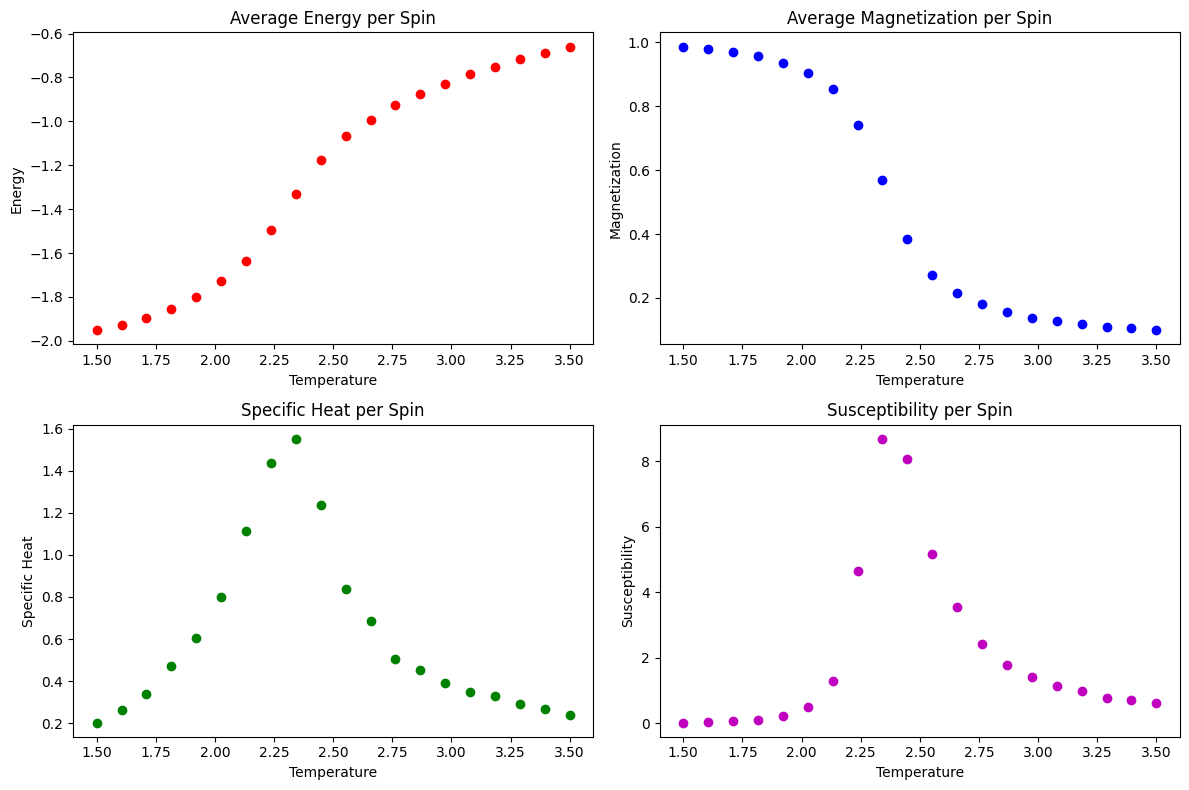

In [12]:
L = 20
steps = 3000
Tmin = 1.5
Tmax = 3.5
Tsteps = 20

T, E, M, C, X = run_temperature_sweep_sw(L, steps, Tmin, Tmax, Tsteps)
plot_vs_temperature(T, E, M, C, X)
